# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [147]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [81]:
# Load the digit data from https://www.openml.org/d/554 or from default local location `~/scikit_learn_data/...`
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape:', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape: (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

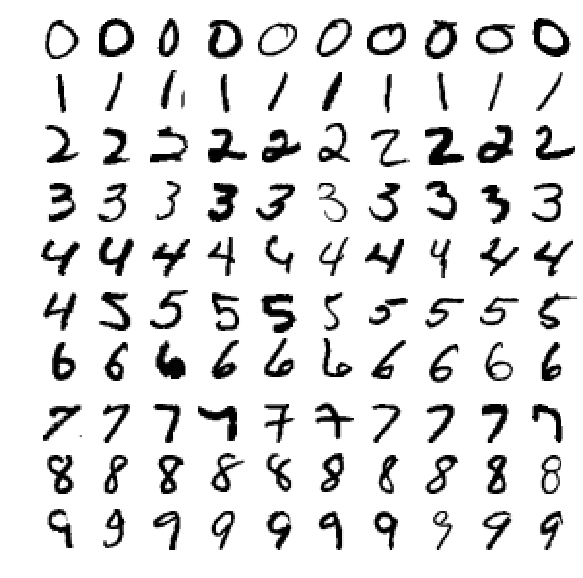

In [67]:
# Now plot the digits in a 10x10 square
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")    
    
def P1(num_examples=10):
### STUDENT START ###
    # The labels are returned as string, convert them to ints
    global Y
    Y = Y.astype(np.int8)

    # These copies are expensive. Doing this here just to keep the original
    # shuffled X & Y around
    X_new = X
    Y_new = Y

    reorder_train = np.array(sorted([(t, i) for i, t in enumerate(Y[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(t, i) for i, t in enumerate(Y[60000:])]))[:, 1]
    X_new[:60000] = X[reorder_train]
    Y_new[:60000] = Y[reorder_train]
    X_new[60000:] = X[reorder_test + 60000]
    Y_new[60000:] = Y[reorder_test + 60000]
    
    plt.figure(figsize=(10,10))
    example_images = np.r_[X_new[:12000:600], X_new[13000:30600:600], X_new[30600:60000:590]]
    plot_digits(example_images, num_examples)
    plt.show()

# The dataset is unsorted. We can sort it using the now numeric values of Y. For this, we
# first create a new array of indices that is created using enumeration on Y, and reversing
# the (index,value) tupe and sorting on the values. Then this array of indices is used to
# restore X, which will now contain image data for sorted numbers.

### STUDENT END ###

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [70]:
def P2(k_values):
    knn_preds = []
    for i in range(len(knn_choices)):
        k = knn_choices[i]
        pred, acc = knn_evaluate(k)
        print("Accuracy is ", acc, "% \tfor k=",k)
        knn_preds.append((k,pred,acc))

# Use the stored predictions to evaluate predictions using k=1
    from sklearn.metrics import classification_report
    i = knn_choices.index(1)
    pred = knn_preds[i][1]
    cfr_report = classification_report(dev_labels, pred)
    print(cfr_report)

### STUDENT START ###
# Prepare a function to fit a kNN classifier on the mini training set.
# Return the predictions and accuracy using the dev data set.
def knn_evaluate(k_val=3):
    knn_cfr = KNeighborsClassifier(k_val)
    # Fit the model using the mini training set
    knn_cfr.fit(mini_train_data, mini_train_labels)
    # Now, collect predictions for the dev data set
    dev_pred = knn_cfr.predict(dev_data)
    # Calculate the accuracy of the predictions by comparing the labels
    # against the predictions returned by the model.
    correct=0
    total = len(dev_pred)
    for i in range(total):
        correct += (dev_pred[i] == dev_labels[i])
    accuracy = (correct * 100)/total
    return dev_pred, accuracy

# Looking at the report, it looks like digit 4 is the most difficult digit to classify.

### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)

Accuracy is  10.3 % 	for k= 1
Accuracy is  9.8 % 	for k= 3
Accuracy is  11.3 % 	for k= 5
Accuracy is  10.4 % 	for k= 7
Accuracy is  10.7 % 	for k= 9
              precision    recall  f1-score   support

           0       0.09      0.13      0.11        83
           1       0.09      0.10      0.10       107
           2       0.16      0.16      0.16        96
           3       0.10      0.08      0.09       101
           4       0.02      0.02      0.02        85
           5       0.10      0.07      0.09        83
           6       0.12      0.11      0.11       104
           7       0.10      0.08      0.09       118
           8       0.12      0.11      0.12       115
           9       0.13      0.16      0.14       108

   micro avg       0.10      0.10      0.10      1000
   macro avg       0.10      0.10      0.10      1000
weighted avg       0.10      0.10      0.10      1000



ANSWER:

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [152]:
def P3(train_sizes, accuracies):

### STUDENT START ###
    # Create a k-NN classifier
    knn_cfr = KNeighborsClassifier(n_neighbors=1, weights='distance', n_jobs=-1)
    # Fit and evalauate in a loop
    for size in train_sizes:
        iter_train_data, iter_train_labels = train_data[:size], train_labels[:size]
        # Fit the model using the mini training set
        knn_cfr.fit(iter_train_data, iter_train_labels)
        # Start the timer for inference
        t_0 = time.time()
        # Now, collect predictions for the dev data set
        dev_pred = knn_cfr.predict(dev_data)
        # Calculate time taken for inference
        t_infer = time.time() - t_0
        # Calculate the accuracy of the predictions
        acc = metrics.accuracy_score(dev_labels, dev_pred)
        print("Size:\t",size,"\tTime (seconds):\t", t_infer,"\tAccuracy:\t",acc)
        accuracies.append(acc)
    
### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

Size:	 100 	Time (seconds):	 0.10482621192932129 	Accuracy:	 0.747
Size:	 200 	Time (seconds):	 0.10778927803039551 	Accuracy:	 0.805
Size:	 400 	Time (seconds):	 0.10646700859069824 	Accuracy:	 0.851
Size:	 800 	Time (seconds):	 0.20888090133666992 	Accuracy:	 0.874
Size:	 1600 	Time (seconds):	 0.4149930477142334 	Accuracy:	 0.9
Size:	 3200 	Time (seconds):	 0.7109560966491699 	Accuracy:	 0.94
Size:	 6400 	Time (seconds):	 1.5483179092407227 	Accuracy:	 0.951
Size:	 12800 	Time (seconds):	 3.2982990741729736 	Accuracy:	 0.963
Size:	 25000 	Time (seconds):	 6.94809889793396 	Accuracy:	 0.966


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

Predicted accuracy for n=60000 is 1.2200852245675289 %


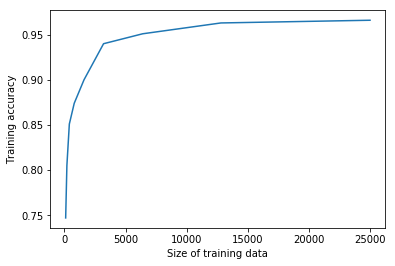

Predicted accuracy for n=60000 is 97.0 %


/Users/vijay/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vijay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [165]:
from sklearn import preprocessing
def P4():

### STUDENT START ###
    X_data = np.array(train_sizes).reshape(-1,1)
    Y_value = np.array(accuracies).reshape(-1,1)

    reg = LinearRegression()
    reg.fit(X_data, Y_value)
    reg.coef_
    reg.intercept_
    pred = reg.predict([[60000]])
    print("Predicted accuracy for n=60000 is", pred[0][0],"%")

    plt.plot(train_sizes, accuracies)
    plt.ylabel('Training accuracy')
    plt.xlabel('Size of training data')
    plt.show()

    # Since the accuracies are decimals, we can convert them into %ages, and then
    # convert them into integers to use LogisticRegression. 
    
    Y_enc = np.ceil(Y_value * 100)
    logit_reg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
    logit_reg.fit(X_data, Y_enc)
    pred = logit_reg.predict([[60000]])
    print("Predicted accuracy for n=60000 is", pred[0],"%")

### STUDENT END ###

P4()

ANSWER:

(5) Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

Digit 4 misclassified as 9 15 times
Digit 9 misclassified as 7 14 times
Digit 5 misclassified as 3 8 times
Digit 2 misclassified as 1 6 times
Digit 3 misclassified as 5 4 times
Digit 7 misclassified as 9 3 times
Digit 8 misclassified as 2 2 times
Digit 6 misclassified as 0 2 times
Digit 0 misclassified as 6 2 times
Digit 1 misclassified as 7 1 times
Displaying some misclassified digits:


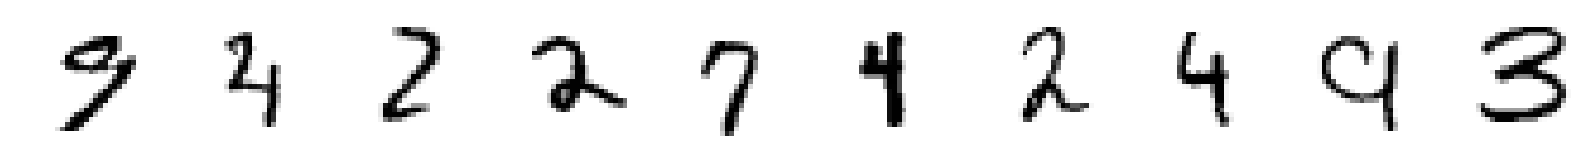

In [145]:
def P5():

### STUDENT START ###
    knn_cfr = KNeighborsClassifier(n_neighbors=1)
    
    knn_cfr.fit(mini_train_data, mini_train_labels)
    dev_pred = knn_cfr.predict(dev_data)
    c_m = confusion_matrix(dev_labels, dev_pred)
    
    most_missed = []
    for i in range(len(c_m[1])):
        for j in range(len(c_m[0])):
            if i == j:
                c_m[i][j] = 0
        i_max = c_m[i].max()
        most_missed.append((i_max,i,np.where(c_m[i] == i_max)[0][0]))
    
    most_missed.sort(reverse=True)
    count=0
    for item in most_missed:
        print("Digit",item[1],"misclassified as",item[2],item[0],"times")
        count += 1
    
    missed_images = []
    total = len(dev_pred)
    for i in range(total):
        if dev_pred[i] != dev_labels[i]:
            missed_images.append(i)
    
    print("Displaying some misclassified digits:")
    fig, axes = plt.subplots(1, 10, figsize=(28,28))
    for i in range(10):
        image = dev_data[missed_images[i]].reshape(28,28)
        axes[i].axis("off")
        axes[i].imshow(image, cmap = mpl.cm.binary)     
    plt.show()
        
    ### STUDENT END ###

P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [8]:
#def P6():
    
### STUDENT START ###


### STUDENT END ###

#P6()

ANSWER:

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [175]:
from sklearn.preprocessing import binarize
def P7():

### STUDENT START ###
    mtd_bin = binarize(mini_train_data)
    nb_cfr = BernoulliNB()
    nb_cfr.fit(mtd_bin, mini_train_labels)
    dd_bin = binarize(dev_data)
    dev_pred = nb_cfr.predict(dd_bin)
    acc = metrics.accuracy_score(dev_labels, dev_pred)
    print("Accuracy with the NB Classifier with binarized data is", acc)

    mtd_s3 = multirize(mini_train_data)
    nb_cfr.fit(mtd_s3, mini_train_labels)
    dd_s3 = multirize(dev_data)
    dev_pred = nb_cfr.predict(dd_s3)
    acc = metrics.accuracy_score(dev_labels, dev_pred)
    print("Accuracy with the NB Classifier with 3-valued data is", acc)

def multirize(A):
    A_copy = A
    c_1 = 1/3
    c_2 = 2/3
    for x in np.nditer(A_copy, op_flags = ['readwrite']):
        if x < c_1:
            x[...] = 0
        elif x < c_2:
            x[...] = 1
        else:
            x[...] = 2
    return A_copy

### STUDENT END ###

P7()

Accuracy with the NB Classifier with binarized data is 0.836
Accuracy with the NB Classifier with 3-valued data is 0.836


ANSWER:

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [183]:
def P8(alphas):

### STUDENT START ###
    mtd_bin = binarize(mini_train_data)

    params = [alphas]
    nb_cfr = BernoulliNB()
    nb_cfr = GridSearchCV(nb_cfr, params, cv=5)

    nb_cfr.fit(mtd_bin, mini_train_labels)

    dd_bin = binarize(dev_data)
    dev_pred = nb_cfr.predict(dd_bin)
    
    acc = metrics.accuracy_score(dev_labels, dev_pred)
    print("Accuracy with the NB Classifier with binarized data is", acc)    
    return nb_cfr

### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

/Users/vijay/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/vijay/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/vijay/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/vijay/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/vijay/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _A

Accuracy with the NB Classifier with binarized data is 0.849


/Users/vijay/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [185]:
print(nb.best_params_)

{'alpha': 0.1}


ANSWER:

(9) Try training a model using GaussianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [206]:
from sklearn.naive_bayes import GaussianNB
def P9():

### STUDENT END ###
    params = [
        {'var_smoothing': [0.01, 0.05, 0.1]}
    ]
    gnb_cfr = GaussianNB(priors=None, var_smoothing=0.25)
    gnb_cfr = GridSearchCV(gnb_cfr, params, cv=5)
    
    gnb_cfr.fit(mini_train_data, mini_train_labels)
    
    print(gnb_cfr.best_params_)
    #print("GNB theta", gnb_cfr.theta_)
    #print("GNB sigma", gnb_cfr.sigma_)
    
    dev_pred = gnb_cfr.predict(dev_data)
    
    acc = metrics.accuracy_score(dev_labels, dev_pred)
    print("Accuracy with the Gaussian NB Classifier with data is", acc)    
    return gnb_cfr

### STUDENT END ###

gnb = P9()

{'var_smoothing': 0.05}
Accuracy with the Gaussian NB Classifier with data is 0.81


ANSWER:

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

In [13]:
#def P10(num_examples):

### STUDENT START ###


### STUDENT END ###

#P10(20)

ANSWER:

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [14]:
#def P11(buckets, correct, total):
    
### STUDENT START ###


                
### STUDENT END ###

#buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
#correct = [0 for i in buckets]
#total = [0 for i in buckets]

#P11(buckets, correct, total)

#for i in range(len(buckets)):
#    accuracy = 0.0
#    if (total[i] > 0): accuracy = correct[i] / total[i]
#    print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)

ANSWER:

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [15]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()